#**Classifying Lung Cancer with Lung CT by Deep Learning**
###Introduction to Brain and Machine Learning, 2020-2
###Korea University, Prof. Seok
###John Leo

#**Used Library for the project**
---
1. **numpy**: For loading data and structuring the data and to standarization the data
2. **tensorflow**: Build the model to classify the data
3. **matplotlib**: To display the loss and accuracy of the model
4. **scikitlearn**: to split the data to train and validation

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
data = np.load("/content/drive/MyDrive/assignment#2/trn_dat.npy")
label = np.load("/content/drive/MyDrive/assignment#2/trn_lbl.npy")

min = np.min(data)
max = np.max(data)

#**PreProcessing of the given Data**
---
##**Class**
###**::DataPreprocessor(data, nClass, nLowerCut, nUpperCut)**
This class split the given data to train and validation. With these splitted data, each dataset preprocessed by the ***Standarization*** to get the more actual predict by the model.

**Before that,** as I researched about the CT image, the CT image can be ranged bt the specific unit that is called ***HU(Hounsfield Unit)***, the range of the Lung is found to range of -600 to -400.

To get the more wider range of the pixel, each images are cutted by little bit wider range, from -900 to -200.

####**Methods**

- **def spliter()**: Split the data to train and validation dataset


- **def Standarization(x_train, x_val)**: Standarization the data with the mean and the standard deviation.


- **def Preprocessor()**:Set the pixels' range from -600 to -200 to get more accurate pixels' range with the image.






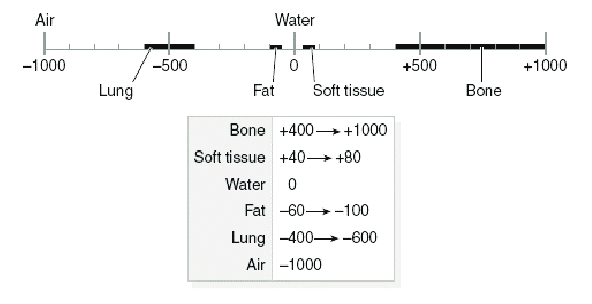

#####Reference: https://www.researchgate.net/figure/The-Hounsfield-scale-of-CT-numbers_fig2_306033192

In [ ]:
class DataPreprocessor:
  def __init__(self, data, label, nClass, nLowerCut, nUpperCut):
    self.data = data
    self.label = label
    self.nClass = nClass
    self.nLowerCut = nLowerCut
    self.nUpperCut = nUpperCut
    self.x_train = self.spliter()[0]
    self.x_val = self.spliter()[1]
    self.y_train = self.spliter()[2]
    self.y_val = self.spliter()[3]
    self.frame = self.data.shape[3]

  def spliter(self):
    x_train, x_val, y_train, y_val = train_test_split(self.data, self.label, test_size=0.1, random_state=18)
    return x_train, x_val, y_train, y_val

  def Standarization(self, x_train, x_val):

      mean = np.zeros((self.frame), dtype='float32')
      std  = np.zeros((self.frame), dtype='float32')

      X_train = np.ones(x_train.shape)
      X_val = np.ones(x_val.shape)
      
      #derive the mean and standard deviation only from the dataset
      for i in range(self.frame):
          mean[i] = np.mean(x_train[:,:,:,i])
          std[i] = np.std(x_train[:,:,:,i])

      print(mean, std)

      #data standarization work with train and validation dataset
      for i in range(self.frame):

          X_train[:,:,:,i] = x_train[:,:,:,i] - mean[i]
          X_train[:,:,:,i] = X_train[:,:,:,i] / std[i]

          X_val[:,:,:,i] = x_val[:,:,:,i] - mean[i]
          X_val[:,:,:,i] = X_val[:,:,:,i] / std[i]

      return X_train, X_val

  def Preprocessor(self):

      x_train = np.where((self.x_train < self.nLowerCut), self.nLowerCut, self.x_train)
      x_train = np.where((self.x_train > self.nUpperCut), self.nUpperCut, self.x_train)


      x_train, x_val = self.Standarization(x_train, self.x_val)
      y_train = to_categorical(self.y_train, self.nClass)
      y_val = to_categorical(self.y_val, self.nClass)
      
      return x_train, y_train, x_val, y_val

Data = DataPreprocessor(data, label, 2, -950, -200).Preprocessor()

x_train, y_train, x_val, y_val = Data

[-683.5113  -683.20935 -682.69055 -681.5584  -679.8325  -677.9535
 -675.62885 -673.42834 -671.9363  -672.0834  -674.40826 -678.119
 -682.25275 -685.9221  -688.7594  -690.94794] [272.24457 271.89212 271.6866  271.82812 272.02277 272.50583 273.10114
 273.8781  274.51743 274.30087 273.28656 271.53915 269.98288 268.83102
 267.9114  267.39877]


#**Create the Model with Keras**
---
###**Methods for constructing the Model**

####**Arguments**
- **nInputDim**: The Shape of the input

- **nodeNum**: The number of the nodes of the layers

- **nKernel**: The size of the Filter

- **nPool**: The size of the Pooling Layer

- **sAct**: The activation function of the Layer
---
**LayerStart(model, nInputDim, nKernel, nPool, sAct)**:

- ***Conv2D -> Activation -> Conv2D -> Activation -> BatchNormalization -> MaxPooling2D***

**LayerAdd2D(model, nodeNum, nKernel, nPool, sAct)**

- ***Conv2D -> Activation -> BatchNormalization -> Conv2D -> Activation -> BatchNormalization -> MaxPooling2D***

**LayerStart1D(model, nInputDim, nodeNum, sAct)**

- ***Dense -> Activation -> BatchNormalization***

**LayerAdd1D(model, nodeNum, sAct)**
- ***Dense -> Activation -> BatchNormalization***

**LayerEnd(model, nClasses, sAct)**
- ***Dense -> Activation***

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import BatchNormalization

def LayerStart(x, nInputDim, nodeNum, nKernel, nPool, sAct):
    x.add(Conv2D(nodeNum, (nKernel, nKernel), padding='same',  input_shape= nInputDim))
    x.add(Activation(sAct))
    x.add(Conv2D(nodeNum, (nKernel, nKernel)))
    x.add(Activation(sAct))
    x.add(BatchNormalization())
    x.add(MaxPooling2D(pool_size=(nPool, nPool)))
    return x, nodeNum


def LayerAdd2D(x, nodeNum, nKernel, nPool, sAct):
    x.add(Conv2D(nodeNum, (nKernel, nKernel), padding='same'))
    x.add(Activation(sAct))
    x.add(BatchNormalization())
    x.add(Conv2D(nodeNum, (nKernel, nKernel)))
    x.add(Activation(sAct))
    x.add(BatchNormalization())
    x.add(MaxPooling2D(pool_size=(nPool, nPool)))
    return x, nodeNum

def LayerStart1D(x, nInputDim, nodeNum, sAct):
    x.add(Dense(nodeNum, input_shape=(nInputDim, ),activation= sAct)) 
    x.add(BatchNormalization()) 
    return x, nodeNum

def LayerAdd1D(x, nodeNum, sAct):
    x.add(Dense(nodeNum, activation= sAct))
    x.add(BatchNormalization()) 
    return x, nodeNum


def LayerEnd(x, nClasses, sAct):
    x.add(Dense(nClasses))
    x.add(Activation(sAct))
    return x

###**Methods for displaying the Loss and Accuracy**
---
- **Display_Loss(hist, sTitle)**: Display the Loss of the Model

- **Display_Accuracy(hist, sTitle)**: Display the Accuracy of the Model


In [ ]:
def Display_Loss(hist, sTitle):

      sTitle = sTitle + '\n Loss-epochs'
      plt.title(sTitle)
      plt.xlabel('epochs')
      plt.ylabel('loss')
      plt.grid()

      plt.plot(hist.history['loss'], label='train loss')
      plt.plot(hist.history['val_loss'], label='validation loss')

      plt.legend(loc='best')

      return plt.show()

def Display_Accuracy(hist, sTitle):

    sTitle = sTitle + '\n Accuracy-Epochs'
    plt.title(sTitle)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.grid()

    plt.plot(hist.history['accuracy'], label='train accuracy')
    plt.plot(hist.history['val_accuracy'], label='validation accuracy')

    plt.legend(loc='best')

    return plt.show()

##**Defining the Model**
---
Impressed by the ResNet, I created the model that optimized to the given Lung Data. The model is more shorter than the ResNet, but the basic Structure of the model is similar with it.

**The Unique** thing is that at the Fully Connected Layers, the **Activation Functions** are set to ***Linear***, which is not recommended to use since the ***Linear*** Activation derives the problems with the BackPropagation.

**However**, here in this model, the ***Linear*** function derived more accurate result with this specific task.

---

###**Convolutional Layer**

***Conv2D -> Activation(RELU) -> Conv2D -> Activation(RELU) -> BatchNormalization -> MaxPooling2D ->***

***Conv2D -> Activation(RELU) -> BatchNormalization -> Conv2D -> Activation(RELU) -> BatchNormalization -> MaxPooling2D ->***

***Conv2D -> Activation(RELU) -> BatchNormalization -> Conv2D -> Activation(RELU) -> BatchNormalization -> MaxPooling2D ->***

***Conv2D -> Activation(RELU) -> BatchNormalization -> Conv2D -> Activation(RELU) -> BatchNormalization -> MaxPooling2D*** ***-> Flatten***



###**Fully Connected**

***Dense -> Activation(LINEAR) -> BatchNormalization ->***
***Dense -> Activation(LINEAR) -> BatchNormalization ->***
***Dense -> Activation(SIGMOID) -> BatchNormalization ->***
***Dense -> Activation(SOFTMAX)***

In [ ]:
class CreateModel:
  def __init__(self, nKernel ,nPool, LearningRate, inputShape):
    self.LearningRate = LearningRate
    self.inputShape = inputShape
    self.nKernel = nKernel
    self.nPool = nPool

  def Model(self):
    nodes = 32

    model = Sequential()
    model, nInput = LayerStart(model, self.inputShape, nodes, self.nKernel, self.nPool,'relu')
    model, nInput = LayerAdd2D(model, nInput*2, self.nKernel, self.nPool,'relu')
    model, nInput = LayerAdd2D(model, nInput, 1, 1, 'relu')
    model, nInput = LayerAdd2D(model, nInput, self.nKernel, self.nPool,'relu')
    model.add(Flatten())

    model, nInput = LayerStart1D(model, nInput, nInput*2, 'linear')
    model, nInput = LayerAdd1D(model, nInput, 'linear')
    model, nInput = LayerAdd1D(model, nInput*2, 'sigmoid')
    model = LayerEnd(model, 2, 'softmax')
    model.summary()
    return model

  def Model_Compile(self):
    Optimizer = Adam(learning_rate=self.LearningRate) # RMSprop Adam
    model = self.Model()
    model.compile(optimizer=Optimizer, loss='categorical_crossentropy' , metrics=['accuracy'])
    return model



##**Training The Model**
---
To train the model, there are used some twicks for optimizing, like scheduler, reducer etc. With the end of the each batch, the callback of the tensorflow optimize the learning rate also with the Optimizers which optimize the weights of the model.

---
- **def scheduler(nEpoch)**: The scheduler that managning the learning rate of the model with the each epoch by training

- **def Model_Train(dir, filename, nBatch, nEpochs, nLearningRate, Data)**

  >**Checkpoints**: Save the checkpoints of the model when the model get the largest accuracy

  >**Scheduler**: Changing the learning rate of the model by each epochs

  >**ImageDataGenerator**: Augment the images  with the various twicks such as flip, 
rotate, zoom, etc.



In [ ]:
from tensorflow.keras.models import save_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

lr_range = 200
learningRate = 0.01
lr_endvalue = 0.0001

def scheduler(nEpoch):# Learning Rate Schedule

    lr = (learningRate - lr_endvalue) * (1 - nEpoch/lr_range )
    if  lr < lr_endvalue:
        lr = lr_endvalue
   
    return lr

def Model_Train(dir, filename, nBatch, nEpochs, nLearningRate, Data):

    x_train, y_train, x_val, y_val = Data

    model = CreateModel(nKernel = 3, nPool = 2, LearningRate = nLearningRate, inputShape = x_train.shape[1:]).Model_Compile()

    str_PathFn = os.path.join(dir, filename)
    str_CkptFn = str_PathFn + "_{epoch:04d} Acc{val_accuracy:.4f} Loss{val_loss:.2f}"

    CheckPoint = ModelCheckpoint(filepath=str_CkptFn, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True) 
    lr_scheduler = LearningRateScheduler(scheduler)
    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

    nCallbacks = [CheckPoint, lr_scheduler, lr_reducer]
    

    nData = ImageDataGenerator(rotation_range=0, width_shift_range=0.05, height_shift_range=0.05, shear_range= 0.05, zoom_range=  [0.9, 1.2], horizontal_flip= True, vertical_flip= True)
    data_flow = nData.flow(x_train, y_train, batch_size=nBatch)

    hist = model.fit_generator(data_flow, epochs=nEpochs, verbose=1, callbacks=[nCallbacks],  validation_data=(x_val, y_val), shuffle=True)

    str_Title = "Model_Fit_Generate Data "
    Display_Loss(hist, str_Title)
    Display_Accuracy(hist, str_Title)
  
    loss, acc = model.evaluate(x_val, y_val, verbose=2)
    save2h5 = str_PathFn + '.h5'
    save_model(model, save2h5, save_format='h5')


    return model

###**Run the training the Model**

In [ ]:
dir = "/content/drive/My Drive/LungComplete2-1"
filename = "Train"
nBatch = 64
nEpochs = 300
nLearningRate = 0.01
model = Model_Train(dir, filename, nBatch, nEpochs, nLearningRate, Data)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
activation_27 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_28 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 15, 15, 64)       

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2520, 32, 32, 16) (16 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/300
40/40 [==============================] - ETA: 0s - loss: 0.9790 - accuracy: 0.6306
Epoch 00001: val_accuracy improved from -inf to 0.51429, saving model to /content/drive/My Drive/LungComplete2-1/Train_0001 Acc0.5143 Loss0.88
40/40 [==============================] - 4s 104ms/step - loss: 0.9790 - accuracy: 0.6306 - val_loss: 0.8799 - val_accuracy: 0.5143
Epoch 2/300
40/40 [==============================] - ETA: 0s - loss: 0.5476 - accuracy: 0.7381
Epoch 00002: val_accuracy improved from 0.51429 to 0.53214, saving model to /content/drive/My Drive/LungComplete2-1/Train_0002 Acc0.5321 Loss1.12
40/40 [==============================] - 4s 96ms/step - loss: 0.5476 - accuracy: 0.7381 - val_loss: 1.1176 - val_accuracy: 0.5321
Epoch 3/300
40/40 [==============================] - ETA: 0s - loss: 0.4504 - accuracy: 0.7905
Epoch 00003: val_accuracy improved from 0.53214 to 0.60714, saving model to /content/drive/My Drive/LungComplete2-1/Train_0003 Acc0.6071 Loss0.72
40/40 [============

#**Discuss and Analysis**
There were so many models that I can twick or choice by the multiple selection of optimizers, loss functions, the ways of preprocessing, etc.

---

###**The Model Architecture**


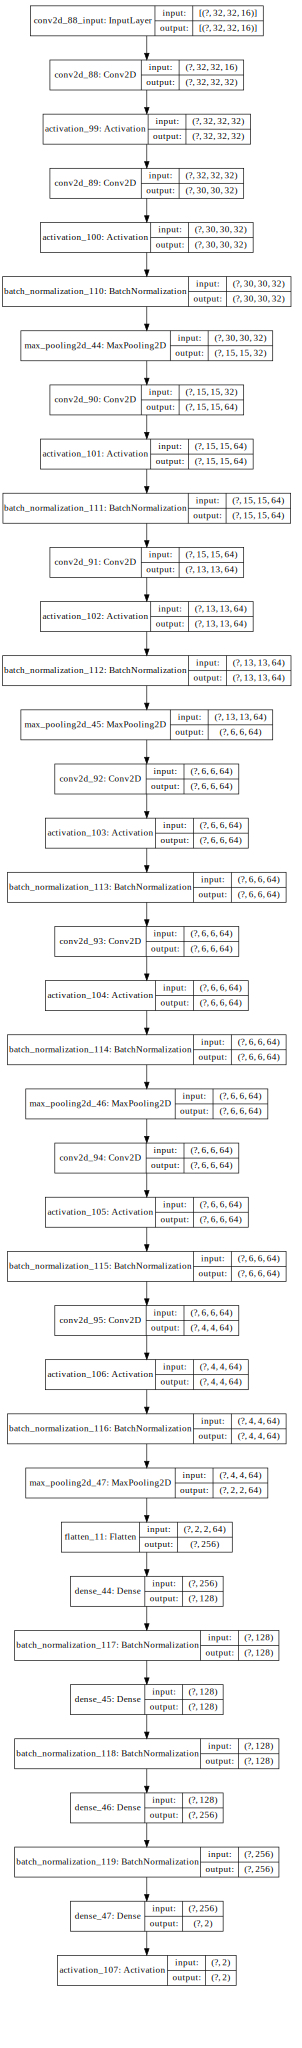

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))


---
###**About the Learning Rate**
With the Various tweaks of learning rate especially, derived the vary results of the models as I run the models, the ***0.01*** of learning rate was most accurate to train the model as I ran. 

---
###**Optimizers**
With the two optimizers between ***RMSProp*** and ***ADAM***, The Adam was more accurate optimizer for the training the model, with the mean of the accuracy for the multiple train results as about

####**Mean of the  multiple training accuracy using**

> ***0.93 (RMSProps) < 0.94 (Adam)***

---

###**About the Activation Functions**

The Activation functions of dense layers, rather than the ***RELU***, the ***Linear*** function derived more accurate results to the models. However, there're hard to find the reasons why the linear function is giving the better results than the RELU.

---

###**Accuracy, Loss of the Train Data**

- ***loss: 0.0031*** 
- ***accuracy: 0.9988***
---
###**Accuracy, Loss of the Validation Data**
- ***val_loss: 0.4978*** 
- ***val_accuracy: 0.9286***

---
##**Conclusion**

The model of the validation accuracy, about 0.928 was not the best accuracy over all experiments, but the way of training all the data derived various results train by train.

The validation loss was derived about 0.4978, still has some room for decrease, but end with the epoch 300.

There were a lots of routes to get the most optimized results, However, it seems to be not easy to derive the detail about each twicks such as controlling the learning rate or the numbers of nodes etc.

Though, the activation function and learning rate would seems to be the most sensitive variables to change the results of the final model.

